# Optimizing Alphabet Soup Charity Funding Predictor -- Deep-Learning

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


* target variable: IS_SUCCESSFUL 
* feature variables: Everything Else

In [2]:
application_df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [3]:
for x in application_df.columns:
    print(x)
    print("----------------------------")
    print(f"{application_df[x].value_counts()}")
    print("")

EIN
----------------------------
471361061    1
716145914    1
470850777    1
742622426    1
436124893    1
            ..
205040320    1
461149136    1
474460867    1
204833477    1
352260098    1
Name: EIN, Length: 34299, dtype: int64

NAME
----------------------------
PARENT BOOSTER USA INC                             1260
TOPS CLUB INC                                       765
UNITED STATES BOWLING CONGRESS INC                  700
WASHINGTON STATE UNIVERSITY                         492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC     408
                                                   ... 
HAMPTON ROADS MEXICAN AMERICAN CLUB SAN ANTONIO       1
MIAMI WEB FEST INC                                    1
GEORGIA SOCIOLOGICAL ASSOCIATION                      1
ATHERTON DISASTER AND PREPAREDNESS TEAM               1
SARKIS MUSIC CORP                                     1
Name: NAME, Length: 19568, dtype: int64

APPLICATION_TYPE
----------------------------
T3     27037
T4      1542

In [4]:
# For this round I am going to drop EIN, APPLICATION TYPE, CLASSIFICATION, AND STATUS. 
# I'm keeping names. If a certain organization is successful more than others it might add weight to the process. 
application_df = application_df.drop(columns=['EIN', 'APPLICATION_TYPE', 'CLASSIFICATION', 'STATUS'])
application_df

,NAME,AFFILIATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,Independent,ProductDev,Association,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,Independent,Preservation,Co-operative,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,CompanySponsored,ProductDev,Association,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,CompanySponsored,Preservation,Trust,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,Independent,Heathcare,Trust,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...
34294,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,Independent,ProductDev,Association,0,N,5000,0
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,CompanySponsored,ProductDev,Association,0,N,5000,0
34296,PTA HAWAII CONGRESS,CompanySponsored,Preservation,Association,0,N,5000,0
34297,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,Independent,ProductDev,Association,0,N,5000,1


In [5]:
# Determine the number unique values in each column. 
application_df.nunique()

NAME                      19568
AFFILIATION                   6
USE_CASE                      5
ORGANIZATION                  4
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [6]:
# Look at organizations for possible binning 
organizations=application_df['NAME'].value_counts()
organizations

PARENT BOOSTER USA INC                             1260
TOPS CLUB INC                                       765
UNITED STATES BOWLING CONGRESS INC                  700
WASHINGTON STATE UNIVERSITY                         492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC     408
                                                   ... 
HAMPTON ROADS MEXICAN AMERICAN CLUB SAN ANTONIO       1
MIAMI WEB FEST INC                                    1
GEORGIA SOCIOLOGICAL ASSOCIATION                      1
ATHERTON DISASTER AND PREPAREDNESS TEAM               1
SARKIS MUSIC CORP                                     1
Name: NAME, Length: 19568, dtype: int64

In [7]:
# There are 19568 total organizations. 19517 appear less than 50 times on the list. 19538 less than 100 times.
organizations[organizations<50].count  
# organizations[organizations<100].count  

<bound method Series.count of AMERICAN YOUTH FOOTBALL INC                                49
AMERICAN ASSOCIATION OF UNIVERSITY WOMEN INC               46
MUSIC TEACHERS NATIONAL ASSOCIATION INC                    46
INTERNATIONAL MOUNTAIN BICYCLING ASSOCIATION - COLORADO    46
MARINE CORPS LEAGUE                                        44
                                                           ..
HAMPTON ROADS MEXICAN AMERICAN CLUB SAN ANTONIO             1
MIAMI WEB FEST INC                                          1
GEORGIA SOCIOLOGICAL ASSOCIATION                            1
ATHERTON DISASTER AND PREPAREDNESS TEAM                     1
SARKIS MUSIC CORP                                           1
Name: NAME, Length: 19517, dtype: int64>

In [8]:
# organizations[organizations<50].plot(kind='bar')

In [9]:
# Choose a cutoff value and create a list of organizations to be replaced
# use the variable name `organizations_to_replace`
organizations_to_replace = list(organizations[organizations < 50].index)

# Replace in dataframe
for org in organizations_to_replace:
    application_df['NAME'] = application_df['NAME'].replace(org,"Other")

# Check to make sure binning was successful
application_df['NAME'].value_counts()

Other                                                                 24545
PARENT BOOSTER USA INC                                                 1260
TOPS CLUB INC                                                           765
UNITED STATES BOWLING CONGRESS INC                                      700
WASHINGTON STATE UNIVERSITY                                             492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                         408
PTA TEXAS CONGRESS                                                      368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                           331
ALPHA PHI SIGMA                                                         313
TOASTMASTERS INTERNATIONAL                                              293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                       287
LITTLE LEAGUE BASEBALL INC                                              277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                                266
MOMS CLUB   

In [10]:
# Check the number of columns I will have
application_df['NAME'].nunique()

52

In [11]:
ask_amt_counts= application_df['ASK_AMT'].value_counts()
ask_amt_counts

5000       25398
10478          3
15583          3
6725           3
63981          3
           ...  
772556         1
70103          1
27096          1
25049          1
1138700        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [12]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
ask_amounts_to_replace = list(ask_amt_counts[ask_amt_counts < 25398].index)

# Replace in dataframe
for amt in ask_amounts_to_replace:
    application_df['ASK_AMT'] = application_df['ASK_AMT'].replace(amt,"Other")

# Check to make sure binning was successful
application_df['ASK_AMT'].value_counts()

5000     25398
Other     8901
Name: ASK_AMT, dtype: int64

In [13]:
# Convert categorical data to numeric with `pd.get_dummies`
application_df = pd.get_dummies(application_df)
application_df

,IS_SUCCESSFUL,NAME_AIR FORCE ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CALIFORNIA GARDEN CLUBS INC,NAME_CISD EDUCATIONAL SUPPORT GROUPS INC,NAME_CIVITAN INTERNATIONAL,NAME_CLEARCREEK I S D SUPPORT GROUPS,...,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_5000,ASK_AMT_Other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
34295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
34296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
34297,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [234]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop(['IS_SUCCESSFUL'], 1).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [235]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

### Set up a Neural Network Opitmizer to Determine the Best Model to Run

In [236]:
# # Create a method that creates a new Sequential model with hyperparameter options
# def create_model(hp):
#     nn_model = tf.keras.models.Sequential()

#     # Allow kerastuner to decide which activation function to use in hidden layers
#     activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
#     # Allow kerastuner to decide number of neurons in first layer
#     nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
#         min_value=1,
#         max_value=10,
#         step=2), activation=activation, input_dim=len(X_train[0])))

#     # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
#     for i in range(hp.Int('num_layers', 1, 6)):
#         nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
#             min_value=1,
#             max_value=10,
#             step=2),
#             activation=activation))
    
#     nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

#     # Compile the model
#     nn_model.compile(loss="binary_crossentropy", optimizer='adagrad', metrics=["accuracy"])
    
#     return nn_model

In [237]:
# # Import the kerastuner library
# import kerastuner as kt

# tuner = kt.Hyperband(
#     create_model,
#     objective="accuracy",
#     max_epochs=20,
#     hyperband_iterations=2)

In [238]:
# # Run the kerastuner search for best hyperparameters
# tuner.search(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))

In [239]:
# # Get best model hyperparameters
# best_hyper = tuner.get_best_hyperparameters(1)[0]
# best_hyper.values

In [240]:
# # Evaluate best model against full test data
# best_model = tuner.get_best_models(1)[0]
# model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [241]:
len(X_train[0])

80

In [255]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 70
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 20
hidden_nodes_layer4 = 40
hidden_nodes_layer5 = 40
hidden_nodes_layer6 = 10
hidden_nodes_layer7 = 10
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
tf.keras.layers.Dense(units=hidden_nodes_layer1,input_dim=number_input_features, activation="sigmoid")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="sigmoid"))

# Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="sigmoid"))

# Sixth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer6, activation="sigmoid"))

# Sixth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer7, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 70)                5670      
_________________________________________________________________
dense_182 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_183 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_184 (Dense)            (None, 40)                840       
_________________________________________________________________
dense_185 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 41        
Total params: 12,761
Trainable params: 12,761
Non-trainable params: 0
_________________________________________________

In [256]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [257]:
#  Create a callback
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create a callback which saves the weights for every 5 epochs
cp_callback= ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, save_freq=5)


In [258]:
# Train the model
fit_model= nn.fit(X_train_scaled, y_train, epochs=30, verbose=1, callbacks=[cp_callback])

Epoch 1/30
804/804 [==============================] - 4s 4ms/step - loss: 0.5839 - accuracy: 0.6915
Epoch 2/30
804/804 [==============================] - 3s 4ms/step - loss: 0.5137 - accuracy: 0.7408
Epoch 3/30
804/804 [==============================] - 4s 4ms/step - loss: 0.5042 - accuracy: 0.7387
Epoch 4/30
804/804 [==============================] - 4s 4ms/step - loss: 0.5015 - accuracy: 0.7401
Epoch 5/30
804/804 [==============================] - 4s 5ms/step - loss: 0.5010 - accuracy: 0.7397
Epoch 6/30
804/804 [==============================] - 3s 4ms/step - loss: 0.4992 - accuracy: 0.7403
Epoch 7/30
804/804 [==============================] - 4s 4ms/step - loss: 0.4986 - accuracy: 0.7404
Epoch 8/30
804/804 [==============================] - 4s 5ms/step - loss: 0.4977 - accuracy: 0.7414
Epoch 9/30
804/804 [==============================] - 4s 5ms/step - loss: 0.4977 - accuracy: 0.7427
Epoch 10/30
804/804 [==============================] - 4s 4ms/step - loss: 0.4978 - accuracy: 0.7406

In [259]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.4908 - accuracy: 0.7503
Loss: 0.4908228814601898, Accuracy: 0.7503206729888916


In [260]:
# Export our model to HDF5 file.
nn.save('AlphabetSoupCharity_Optimization.h5')

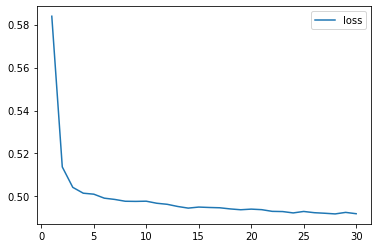

In [261]:
# Create a DataFrame containing training history.
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs.
history_df.index += 1

# Plot the loss.
history_df.plot(y="loss");

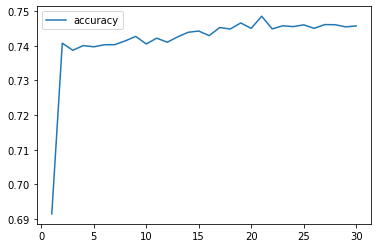

In [262]:
# Plot the accuracy.
history_df.plot(y="accuracy");